In [29]:
import pandas as pd
import os
import hdbscan
import folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors

In [30]:
os.chdir('c:/Users/artur/OneDrive/Documents/TrabajoTesis') 


In [31]:
df = pd.read_csv('Cluster/df_faenas_y_desaladoras_y_puertos_y_estaciones.csv')

In [ ]:
#df = df.drop(columns = ['categorias_10km'])

KeyError: "['categorias_10km'] not found in axis"

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RutEmpresa               21158 non-null  object 
 1   NombreEmpresa            21158 non-null  object 
 2   CategoriaFaena           21158 non-null  object 
 3   RegionInstalacion        21158 non-null  object 
 4   TipoInstalacion          21158 non-null  object 
 5   Cota                     21158 non-null  int64  
 6   Huso                     21158 non-null  int64  
 7   Estado                   21158 non-null  object 
 8   Latitud                  21158 non-null  float64
 9   Longitud                 21158 non-null  float64
 10  faenas_10km              21158 non-null  int64  
 11  categoriaA_10km          21158 non-null  int64  
 12  Closest_City             21158 non-null  object 
 13  Distancia_ciudad         21158 non-null  float64
 14  Tiempo_ciudad         

In [34]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Select variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_filtered = df[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_filtered - df_filtered.mean()) / df_filtered.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df.loc[mask].copy()

# === Step 3: Scale the features (important for HDBSCAN) ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 25 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


KeyError: "['Travel_min', 'travel_time_desal'] not in index"

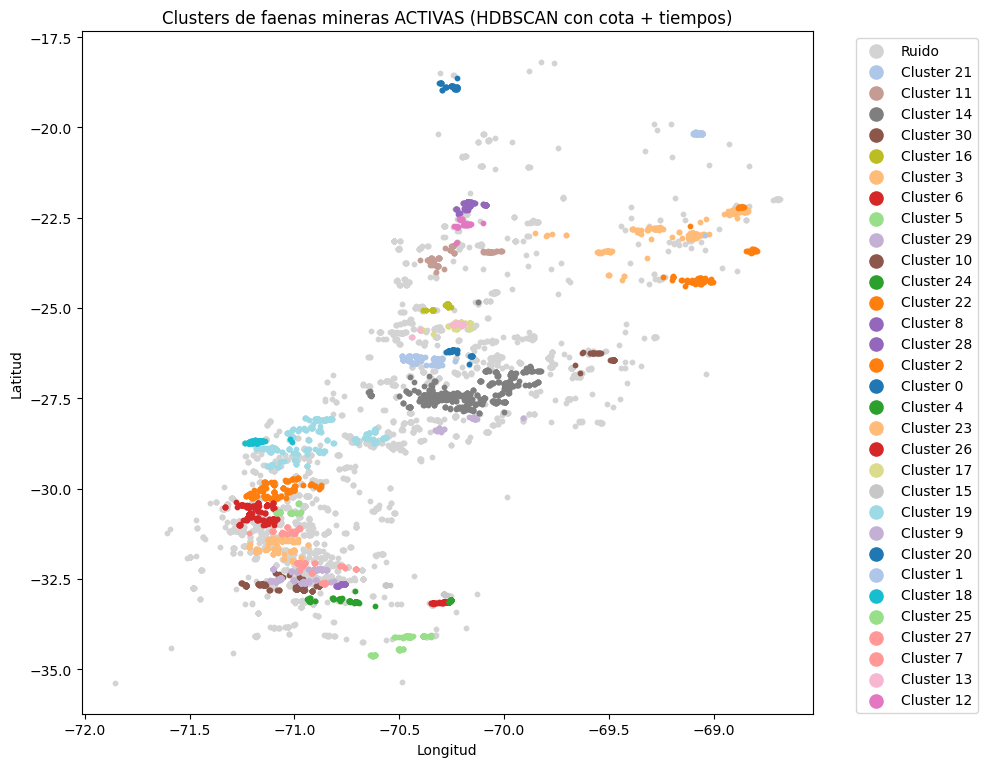

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.35,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")


C:\Users\artur\AppData\Local\Temp\ipykernel_15524\4020827223.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html
